In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_regression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [2]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/data

/content/drive/MyDrive/data


In [12]:
logdiff = pd.read_csv("logdiff_did.csv")

# Defining treatment groups

In [13]:
early_legalization = ['CA','WA','HI','AK','NY']

In [14]:
logdiff

,Unnamed: 0,agency_name,state_abb,year,population,violent_crime,property_crime,per capita personal income,poverty_rate,beer_pc,group,jobpop ratio
0,7,anchorage,AK,2014,0.006162,0.065674,-0.042531,0.054558,0.087776,0.036701,AKanchorage,-0.012342
1,8,anchorage,AK,2013,0.001042,-0.097983,0.132108,-0.032239,0.086178,-0.089345,AKanchorage,0.002335
2,9,anchorage,AK,2012,0.007341,0.004385,0.108918,0.012826,-0.157004,0.017242,AKanchorage,0.017369
3,10,anchorage,AK,2011,0.017423,0.054018,-0.077216,0.037006,-0.066140,-0.067252,AKanchorage,-0.008784
4,11,anchorage,AK,2010,0.029651,-0.063639,-0.009937,0.050349,0.066140,-0.070618,AKanchorage,-0.029701
...,...,...,...,...,...,...,...,...,...,...,...,...
330415,1031397,newcastle,WY,1978,-0.000000,-1.504077,-0.666479,0.086614,NaN,0.016713,WYnewcastle,0.062756
330416,1031398,newcastle,WY,1977,0.055202,-0.441833,0.392042,0.109393,NaN,NaN,WYnewcastle,-0.010689
330417,1031399,newcastle,WY,1976,0.046763,1.029619,-0.058269,0.000431,NaN,NaN,WYnewcastle,-0.020285
330418,1031400,newcastle,WY,1975,-0.012999,-0.875469,-0.219363,0.143112,NaN,NaN,WYnewcastle,0.043166


In [15]:
logdiff['treatment_el'] = logdiff['state_abb'].isin(early_legalization).astype(int)

In [16]:
top_quartile_states = [
    'NY',
    'MD',
    'CA',
    'NJ',
    'MA',
    'WA',
    'FL',
    'CT',
    'DE',
    'VA',
    'IL',
    'HI',
    'NV'
]
bottom_quartile_states = [
    'OK',
    'KY',
    'AR',
    'WV',
    'AL',
    'NE',
    'SD',
    'LA',
    'MN',
    'ND',
    'MS',
    'ID',
    'UT',
]

states = top_quartile_states + bottom_quartile_states

#logdiff = logdiff[logdiff['state_abb'].isin(states)]
logdiff['treatment_hl'] = logdiff['state_abb'].isin(top_quartile_states).astype(int)

# Lag 15, 20, 25 years
- 15:
    - before period: 1970-1987
    - after period: 1988-2014
- 20:
    - before period: 1970-1992
    - after period: 1993-2014
- 25:
    - before period: 1970-1997
    - after period: 1998-2014

In [17]:
lag_15_before = list(range(1970,1988))
lag_15_after = list(range(1988,2015))

lag_20_before = list(range(1970,1993))
lag_20_after = list(range(1993,2015))

lag_25_before = list(range(1970,1998))
lag_25_after = list(range(1998,2015))

In [18]:
logdiff['lag_15_before'] = (logdiff['year'].isin(lag_15_before))
logdiff['lag_20_before'] = logdiff['year'].isin(lag_20_before)
logdiff['lag_25_before'] = logdiff['year'].isin(lag_25_before)

In [19]:
logdiff.head()

,Unnamed: 0,agency_name,state_abb,year,population,violent_crime,property_crime,per capita personal income,poverty_rate,beer_pc,group,jobpop ratio,treatment_el,treatment_hl,lag_15_before,lag_20_before,lag_25_before
0,7,anchorage,AK,2014,0.006162,0.065674,-0.042531,0.054558,0.087776,0.036701,AKanchorage,-0.012342,1,0,False,False,False
1,8,anchorage,AK,2013,0.001042,-0.097983,0.132108,-0.032239,0.086178,-0.089345,AKanchorage,0.002335,1,0,False,False,False
2,9,anchorage,AK,2012,0.007341,0.004385,0.108918,0.012826,-0.157004,0.017242,AKanchorage,0.017369,1,0,False,False,False
3,10,anchorage,AK,2011,0.017423,0.054018,-0.077216,0.037006,-0.066140,-0.067252,AKanchorage,-0.008784,1,0,False,False,False
4,11,anchorage,AK,2010,0.029651,-0.063639,-0.009937,0.050349,0.066140,-0.070618,AKanchorage,-0.029701,1,0,False,False,False


## Two ways of aggregating across before and after periods:
- sum: cummulative percent change
- mean: average percent change

## Mean aggregation

In [20]:
# lag 15
lag_15 = logdiff.copy()
a = pd.DataFrame(lag_15.groupby('group')['lag_15_before'].nunique()==2).reset_index()
a = a[a['lag_15_before']==True]
lag_15 = lag_15[lag_15['group'].isin(list(a['group']))]

# lag 20
lag_20 = logdiff.copy()
a = pd.DataFrame(lag_20.groupby('group')['lag_20_before'].nunique()==2).reset_index()
a = a[a['lag_20_before']==True]
lag_20 = lag_20[lag_20['group'].isin(list(a['group']))]

# lag 25
lag_25 = logdiff.copy()
a = pd.DataFrame(lag_25.groupby('group')['lag_25_before'].nunique()==2).reset_index()
a = a[a['lag_25_before']==True]
lag_25 = lag_25[lag_25['group'].isin(list(a['group']))]

In [21]:
lag_15 = lag_15.groupby(['agency_name','state_abb','lag_15_before']).mean()
lag_15 = lag_15.reset_index()

lag_20 = lag_20.groupby(['agency_name','state_abb','lag_20_before']).mean()
lag_20 = lag_20.reset_index()

lag_25 = lag_25.groupby(['agency_name','state_abb','lag_25_before']).mean()
lag_25 = lag_25.reset_index()

# Sum aggregation

In [22]:
subset_mean_lag15 = logdiff.copy()
subset_mean_lag20 = subset_mean_lag15.copy()
subset_mean_lag25 = subset_mean_lag15.copy()

In [23]:
subset_mean_lag15['lag15'] = (subset_mean_lag15['year']>=1985)
subset_mean_lag20['lag20'] = (subset_mean_lag20['year']>=1990)
subset_mean_lag25['lag25'] = (subset_mean_lag25['year']>=1995)

In [24]:
## sum all of the percent change variables for cummulative percent change, average all of the logged variables
agg_dict = {'violent_crime': 'sum',
            'property_crime':'sum',
            'jobpop ratio':'sum',
            'per capita personal income':'sum',
            'population':'sum',
            #'log_population':'mean',
            'poverty_rate':'mean',
            'beer_pc':'mean',
            #'ln_lag_police_pc':'mean',
            #'ln_lag_prison_pc':'mean',
            'year':'mean',
            }

In [25]:
subset_mean_lag15 = subset_mean_lag15.groupby(['agency_name', 'state_abb', 'lag15','treatment_hl','treatment_el']).agg(agg_dict).reset_index()

In [26]:
subset_mean_lag20 = subset_mean_lag20.groupby(['agency_name', 'state_abb', 'lag20','treatment_hl','treatment_el']).agg(agg_dict).reset_index()
subset_mean_lag25 = subset_mean_lag25.groupby(['agency_name', 'state_abb', 'lag25','treatment_hl','treatment_el']).agg(agg_dict).reset_index()

In [27]:
subset_mean_lag15 = subset_mean_lag15[subset_mean_lag15["year"].isin([1979,1999.5])]
subset_mean_lag20 = subset_mean_lag20[subset_mean_lag20["year"].isin([1981.5,2002])]
subset_mean_lag25 = subset_mean_lag25[subset_mean_lag25["year"].isin([1984,2004.5])]

In [28]:
subset_mean_lag15 = subset_mean_lag15.reset_index()
subset_mean_lag20 = subset_mean_lag20.reset_index()
subset_mean_lag25 = subset_mean_lag25.reset_index()

In [29]:
subset_mean_lag15

,index,agency_name,state_abb,lag15,treatment_hl,treatment_el,violent_crime,property_crime,jobpop ratio,per capita personal income,population,poverty_rate,beer_pc,year
0,0,abbeville,AL,False,0,0,-2.442347e+00,-0.599621,-0.003853,0.991328,-0.002950,0.002105,0.008574,1979.0
1,1,abbeville,AL,True,0,0,3.044522e+00,1.110447,0.173953,1.281953,-0.141915,-0.002350,0.003089,1999.5
2,2,abbeville,LA,False,0,0,1.872115e-01,0.827191,0.124075,1.075688,0.116512,0.020426,0.015949,1979.0
3,3,abbeville,LA,True,0,0,1.112579e+00,2.412284,0.242443,1.370787,-0.067866,0.003818,-0.002943,1999.5
4,4,aberdeen,MD,False,1,0,1.205647e-01,-0.145266,0.302623,1.042179,-0.122052,-0.023812,-0.005351,1979.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16101,16113,zephyrhills,FL,True,1,0,3.042669e+00,0.793199,0.146892,1.134443,0.780505,0.003357,-0.009742,1999.5
16102,16114,ziebach,SD,False,0,0,-1.386294e+00,-0.693147,-0.075093,0.722098,0.046520,-0.030633,0.014063,1979.0
16103,16115,ziebach,SD,True,0,0,-4.440892e-16,-2.397895,0.241591,1.044292,-0.136230,-0.004157,0.005287,1999.5
16104,16116,zion,IL,False,1,0,1.100847e+00,0.366625,0.227043,1.013914,0.066415,0.062031,0.009423,1979.0


In [30]:
subset_mean_lag15['group'] = subset_mean_lag15['agency_name']+subset_mean_lag15['state_abb']
a = pd.DataFrame(subset_mean_lag15.groupby('group')['lag15'].nunique()==2)
a = a[a['lag15']==True]
a = a.reset_index()
filt = list(a['group'])
subset_mean_lag15 = subset_mean_lag15[subset_mean_lag15['group'].isin(filt)]
subset_mean_lag15

,index,agency_name,state_abb,lag15,treatment_hl,treatment_el,violent_crime,property_crime,jobpop ratio,per capita personal income,population,poverty_rate,beer_pc,year,group
0,0,abbeville,AL,False,0,0,-2.442347e+00,-0.599621,-0.003853,0.991328,-0.002950,0.002105,0.008574,1979.0,abbevilleAL
1,1,abbeville,AL,True,0,0,3.044522e+00,1.110447,0.173953,1.281953,-0.141915,-0.002350,0.003089,1999.5,abbevilleAL
2,2,abbeville,LA,False,0,0,1.872115e-01,0.827191,0.124075,1.075688,0.116512,0.020426,0.015949,1979.0,abbevilleLA
3,3,abbeville,LA,True,0,0,1.112579e+00,2.412284,0.242443,1.370787,-0.067866,0.003818,-0.002943,1999.5,abbevilleLA
4,4,aberdeen,MD,False,1,0,1.205647e-01,-0.145266,0.302623,1.042179,-0.122052,-0.023812,-0.005351,1979.0,aberdeenMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16101,16113,zephyrhills,FL,True,1,0,3.042669e+00,0.793199,0.146892,1.134443,0.780505,0.003357,-0.009742,1999.5,zephyrhillsFL
16102,16114,ziebach,SD,False,0,0,-1.386294e+00,-0.693147,-0.075093,0.722098,0.046520,-0.030633,0.014063,1979.0,ziebachSD
16103,16115,ziebach,SD,True,0,0,-4.440892e-16,-2.397895,0.241591,1.044292,-0.136230,-0.004157,0.005287,1999.5,ziebachSD
16104,16116,zion,IL,False,1,0,1.100847e+00,0.366625,0.227043,1.013914,0.066415,0.062031,0.009423,1979.0,zionIL


In [31]:
subset_mean_lag20['group'] = subset_mean_lag20['agency_name']+subset_mean_lag20['state_abb']
a = pd.DataFrame(subset_mean_lag20.groupby('group')['lag20'].nunique()==2)
a = a[a['lag20']==True]
a = a.reset_index()
filt = list(a['group'])
subset_mean_lag20 = subset_mean_lag20[subset_mean_lag20['group'].isin(filt)]
subset_mean_lag20

,index,agency_name,state_abb,lag20,treatment_hl,treatment_el,violent_crime,property_crime,jobpop ratio,per capita personal income,population,poverty_rate,beer_pc,year,group
0,0,abbeville,AL,False,0,0,1.226023e-01,0.973449,0.154453,1.251418,-0.062816,-8.326673e-18,0.011982,1981.5,abbevilleAL
1,1,abbeville,AL,True,0,0,4.795731e-01,-0.462624,0.015647,1.021864,-0.082049,-2.398539e-03,0.000356,2002.0,abbevilleAL
2,2,abbeville,LA,False,0,0,1.872115e-01,0.827191,0.043986,1.167443,0.086745,2.252918e-02,0.012187,1981.5,abbevilleLA
3,3,abbeville,LA,True,0,0,1.112579e+00,2.412284,0.322533,1.279031,-0.038099,-3.448297e-04,-0.004916,2002.0,abbevilleLA
4,4,aberdeen,MD,False,1,0,-5.586607e-03,-0.082276,0.513200,1.304808,-0.073008,-8.515781e-03,-0.010430,1981.5,aberdeenMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16101,16113,zephyrhills,FL,True,1,0,2.436533e+00,0.174353,0.070677,0.858425,0.630144,1.158720e-02,-0.013037,2002.0,zephyrhillsFL
16102,16114,ziebach,SD,False,0,0,-1.386294e+00,-0.693147,-0.124205,0.514507,0.077759,-2.470968e-02,0.009495,1981.5,ziebachSD
16103,16115,ziebach,SD,True,0,0,-4.440892e-16,-2.397895,0.290702,1.251884,-0.167470,-1.230866e-03,0.005724,2002.0,ziebachSD
16104,16116,zion,IL,False,1,0,1.114151e+00,0.078118,0.411980,1.365501,0.095730,1.437067e-02,0.006085,1981.5,zionIL


In [32]:
subset_mean_lag25['group'] = subset_mean_lag25['agency_name']+subset_mean_lag25['state_abb']
a = pd.DataFrame(subset_mean_lag25.groupby('group')['lag25'].nunique()==2)
a = a[a['lag25']==True]
a = a.reset_index()
filt = list(a['group'])
subset_mean_lag25 = subset_mean_lag25[subset_mean_lag25['group'].isin(filt)]
subset_mean_lag25

,index,agency_name,state_abb,lag25,treatment_hl,treatment_el,violent_crime,property_crime,jobpop ratio,per capita personal income,population,poverty_rate,beer_pc,year,group
0,0,abbeville,AL,False,0,0,8.718390e-01,0.462624,0.039522,1.492992,0.030305,-0.009459,1.052231e-02,1984.0,abbevilleAL
1,1,abbeville,AL,True,0,0,-2.696636e-01,0.048202,0.130579,0.780289,-0.175170,0.004096,-1.310119e-03,2004.5,abbevilleAL
2,2,abbeville,LA,False,0,0,1.332781e+00,3.081402,0.284713,1.463988,-0.048042,0.021555,7.796862e-03,1984.0,abbevilleLA
3,3,abbeville,LA,True,0,0,-3.299028e-02,0.158073,0.081805,0.982486,0.096688,-0.005333,-5.459965e-03,2004.5,abbevilleLA
4,4,aberdeen,MD,False,1,0,4.745199e-01,-0.034040,0.494811,1.474322,0.034164,0.005857,-1.301806e-02,1984.0,aberdeenMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16101,16113,zephyrhills,FL,True,1,0,5.147205e-01,0.423969,0.128110,0.715678,0.509745,0.005702,-1.251473e-02,2004.5,zephyrhillsFL
16102,16114,ziebach,SD,False,0,0,-1.386294e+00,-0.693147,0.184919,0.772266,-0.030098,-0.010211,1.021550e-02,1984.0,ziebachSD
16103,16115,ziebach,SD,True,0,0,-4.440892e-16,-2.397895,-0.018422,0.994124,-0.059612,-0.006235,4.169080e-03,2004.5,ziebachSD
16104,16116,zion,IL,False,1,0,6.590142e-01,-0.851473,0.452621,1.584257,0.188516,0.007987,5.510298e-18,1984.0,zionIL


In [33]:
confounder_vars = ['per capita personal income',
                   'jobpop ratio','population',
                   #'log_population',
                   'poverty_rate','beer_pc',
                   #'ln_lag_police_pc','ln_lag_prison_pc'
                   ]

In [34]:
def prep_df(df,crime_type,first_period,treatment):
    compact_df = df[~df[first_period]]
    crime = df[crime_type].values
    compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
    
    compact_df['per capita personal income'] = \
    compact_df.groupby("state_abb")['per capita personal income'].transform(lambda x: x.fillna(x.mean()))
    compact_df['jobpop ratio'] = \
    compact_df.groupby("state_abb")['jobpop ratio'].transform(lambda x: x.fillna(x.mean()))
    
    compact_df = compact_df[(compact_df['Y1-Y0'].notna()) & (~compact_df['Y1-Y0'].isin([np.inf, -np.inf]))]
    compact_df = compact_df.reset_index()
    
    outcome = compact_df['Y1-Y0']
    treatment = compact_df[treatment]
    confounders = compact_df[confounder_vars]
    
    #cont_vars = ['per capita personal income', 'population']
    #confounders[cont_vars] = preprocessing.scale(confounders[cont_vars])
    
    return outcome, treatment, confounders, compact_df

## Model Selection:
- just doing model selection based on lag 15 for the mean aggregated data for violent crime
- g model:
  - Logistic Regression
  - Random Forest Classifier (depth 2 and 5)
  - XGBoost
- Q model:
  - Linear Regression
  - Random Forest Regressor (depth 5 and 10)
  - XGBoost

In [35]:
g_models = [LogisticRegression(),
            RandomForestClassifier(max_depth=2),
            RandomForestClassifier(max_depth=5),
            xgb.XGBClassifier(),
            KNeighborsClassifier(n_neighbors=300)
            ]
Q_models = [LinearRegression(), 
            RandomForestRegressor(max_depth=5), 
            RandomForestRegressor(max_depth=10),
            xgb.XGBRegressor(),
            KNeighborsRegressor(n_neighbors=300)]

In [36]:
# treatment: upper quartile abortion rate

outcome, treatment, confounders, compact_df = \
prep_df(lag_15, 'property_crime', 'lag_15_before','treatment_hl')

<ipython-input-34-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-34-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-34-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [37]:
X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)

In [38]:
for g_model in g_models:
    g_model.fit(X_train, a_train)
    a_pred = g_model.predict_proba(X_test)[:,1]

    print(g_model)
    test_ce=log_loss(a_test, a_pred)
    print(f"Test CE of fit model {test_ce}") 
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    print(f"Test CE of no-covariate model {baseline_ce}")

LogisticRegression()
Test CE of fit model 0.5776753700388765
Test CE of no-covariate model 0.6038758122179737
RandomForestClassifier(max_depth=2)
Test CE of fit model 0.27037148507215125
Test CE of no-covariate model 0.6038758122179737
RandomForestClassifier(max_depth=5)
Test CE of fit model 0.07099006270876711
Test CE of no-covariate model 0.6038758122179737
XGBClassifier()
Test CE of fit model 0.00719173648020465
Test CE of no-covariate model 0.6038758122179737
KNeighborsClassifier(n_neighbors=300)
Test CE of fit model 0.3146300866308654
Test CE of no-covariate model 0.6038758122179737


In [39]:
X_train, X_test, y_train, y_test = train_test_split(confounders, outcome, test_size=0.2)

In [40]:
for Q_model in Q_models:
    Q_model.fit(X_train, y_train)
    y_pred = Q_model.predict(X_test)

    print(Q_model)
    test_mse=mean_squared_error(y_pred, y_test)
    print(f"Test MSE of fit model {test_mse}") 
    baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
    print(f"Test MSE of no-covariate model {baseline_mse}")

LinearRegression()
Test MSE of fit model 0.013808863057741278
Test MSE of no-covariate model 0.013769342455740814
RandomForestRegressor(max_depth=5)
Test MSE of fit model 0.01353721826968133
Test MSE of no-covariate model 0.013769342455740814
RandomForestRegressor(max_depth=10)
Test MSE of fit model 0.01354421556838357
Test MSE of no-covariate model 0.013769342455740814
[19:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor()
Test MSE of fit model 0.013386641278032662
Test MSE of no-covariate model 0.013769342455740814
KNeighborsRegressor(n_neighbors=300)
Test MSE of fit model 0.013721576368880425
Test MSE of no-covariate model 0.013769342455740814


Decided to go with XGBRegressor and XGBClassifer

# Overlap Condition

In [43]:
# violent crime, mean aggregation

ct = 'violent_crime'
lag_dict = {15:lag_15}
#,20:lag_20,25:lag_25}
for lag in lag_dict.keys():
    print(lag)
    outcome, treatment, confounders, compact_df = prep_df(lag_dict[lag], ct, 'lag_'+str(lag)+'_before','treatment_hl')
    

    
    g_model = make_g_model()
    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(X_train, a_train)
    a_pred = g_model.predict_proba(X_test)[:,1]

    print("G model")
    test_ce=log_loss(a_test, a_pred)
    print(f"Test CE of fit model {test_ce}") 
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    print(f"Test CE of no-covariate model {baseline_ce}")

15


<ipython-input-34-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-34-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-34-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

G model
Test CE of fit model 0.009450649711959585
Test CE of no-covariate model 0.6032814636060021


(array([1.128e+03, 1.000e+01, 4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 4.680e+02]),
 array([1.3962408e-04, 9.9694356e-02, 1.9924909e-01, 2.9880384e-01,
        3.9835855e-01, 4.9791330e-01, 5.9746802e-01, 6.9702274e-01,
        7.9657751e-01, 8.9613223e-01, 9.9568695e-01], dtype=float32),
 <a list of 10 Patch objects>)

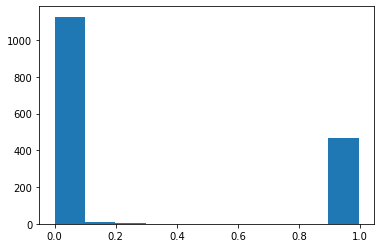

In [44]:
hist(a_pred)

In [46]:
df_a_pred = pd.DataFrame(a_pred)

In [48]:
df_a_pred[df_a_pred[0]==0]

,0


In [49]:
df_a_pred[df_a_pred[0]==1]

,0


# Models

In [42]:
def make_Q_model():
  # return LinearRegression()
 #return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=100, max_depth=5)
  return xgb.XGBRegressor()


def make_g_model():
#  return LogisticRegression(max_iter=1000)
  #return RandomForestClassifier(n_estimators=100, max_depth=2)
  return xgb.XGBClassifier()

# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATT
  This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
  """

  if prob_t is None:
    prob_t = A.mean() # estimate marginal probability of treatment

  tau_hat = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0)).mean()/ prob_t
  
  scores = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0) - tau_hat*A) / prob_t
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


# Running Models

## Mean Aggregation

Violent crime, mean aggregation

In [68]:
ct = 'violent_crime'
lag_dict = {15:lag_15,20:lag_20,25:lag_25}
for lag in lag_dict.keys():
    print(lag)
    outcome, treatment, confounders, compact_df = prep_df(lag_dict[lag], ct, 'lag_'+str(lag)+'_before','treatment_hl')
    

    
    Q_model = make_Q_model()

    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_w_treatment = confounders.copy()
    X_w_treatment["treatment"] = treatment

    X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
    Q_model.fit(X_train, y_train)
    y_pred = Q_model.predict(X_test)

    print("Q model")
    test_mse=mean_squared_error(y_pred, y_test)
    print(f"Test MSE of fit model {test_mse}") 
    baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
    print(f"Test MSE of no-covariate model {baseline_mse}")
    
    g_model = make_g_model()
    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(X_train, a_train)
    a_pred = g_model.predict_proba(X_test)[:,1]

    print("G model")
    test_ce=log_loss(a_test, a_pred)
    print(f"Test CE of fit model {test_ce}") 
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    print(f"Test CE of no-covariate model {baseline_ce}")
    
    
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")
    data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})


    
    tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates)
    print(f"The estimate is {tau_hat} pm {1.96*std_hat}")
    print(outcome[treatment==1].mean()-outcome[treatment==0].mean())
    

15
[20:13:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 0.01896139595156122
Test MSE of no-covariate model 0.019595201782378127
G model
Test CE of fit model 0.014031200040944873
Test CE of no-covariate model 0.5825974766345561
[20:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:23] WARNING: /workspace/src/ob

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 0.014480930426548112
Test MSE of no-covariate model 0.015486570497000482
G model
Test CE of fit model 0.0037398878177496483
Test CE of no-covariate model 0.5848276109801435
[20:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:30] WARNING: /workspace/src/

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 0.015388985297345925
Test MSE of no-covariate model 0.016432531307048956
G model
Test CE of fit model 0.012519233347833614
Test CE of no-covariate model 0.5853877901634117
[20:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:38] WARNING: /workspace/src/o

Property crime, mean aggregation

In [69]:
ct = 'property_crime'
lag_dict = {15:lag_15,20:lag_20,25:lag_25}
for lag in lag_dict.keys():
    print(lag)
    outcome, treatment, confounders, compact_df = prep_df(lag_dict[lag], ct, 'lag_'+str(lag)+'_before','treatment_hl')
    

    
    Q_model = make_Q_model()

    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_w_treatment = confounders.copy()
    X_w_treatment["treatment"] = treatment

    X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
    Q_model.fit(X_train, y_train)
    y_pred = Q_model.predict(X_test)

    print("Q model")
    test_mse=mean_squared_error(y_pred, y_test)
    print(f"Test MSE of fit model {test_mse}") 
    baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
    print(f"Test MSE of no-covariate model {baseline_mse}")
    
    g_model = make_g_model()
    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(X_train, a_train)
    a_pred = g_model.predict_proba(X_test)[:,1]

    print("G model")
    test_ce=log_loss(a_test, a_pred)
    print(f"Test CE of fit model {test_ce}") 
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    print(f"Test CE of no-covariate model {baseline_ce}")
    
    
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")
    data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})


    
    tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates)
    print(f"The estimate is {tau_hat} pm {1.96*std_hat}")
    print(outcome[treatment==1].mean()-outcome[treatment==0].mean())
    

15
[20:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 0.014512431553325442
Test MSE of no-covariate model 0.01485955865682349
G model
Test CE of fit model 0.014498385210570194
Test CE of no-covariate model 0.597980697928003
[20:15:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:07] WARNING: /workspace/src/obj

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 0.011511844357339124
Test MSE of no-covariate model 0.011843697527510967
G model
Test CE of fit model 0.0041191618499936385
Test CE of no-covariate model 0.5927667132843246
[20:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:15] WARNING: /workspace/src/

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 0.012319080533572089
Test MSE of no-covariate model 0.01253243494105439
G model
Test CE of fit model 0.01382229848505466
Test CE of no-covariate model 0.5927667132843246
[20:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:24] WARNING: /workspace/src/obj

## Sum aggregation

In [72]:
ct = 'violent_crime'
lag_dict = {15:subset_mean_lag15,20:subset_mean_lag20,25:subset_mean_lag25}
for lag in lag_dict.keys():
    print(lag)
    outcome, treatment, confounders, compact_df = prep_df(lag_dict[lag], ct, 'lag'+str(lag),'treatment_hl')
    

    
    Q_model = make_Q_model()

    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_w_treatment = confounders.copy()
    X_w_treatment["treatment"] = treatment

    X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
    Q_model.fit(X_train, y_train)
    y_pred = Q_model.predict(X_test)

    print("Q model")
    test_mse=mean_squared_error(y_pred, y_test)
    print(f"Test MSE of fit model {test_mse}") 
    baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
    print(f"Test MSE of no-covariate model {baseline_mse}")
    
    g_model = make_g_model()
    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(X_train, a_train)
    a_pred = g_model.predict_proba(X_test)[:,1]

    print("G model")
    test_ce=log_loss(a_test, a_pred)
    print(f"Test CE of fit model {test_ce}") 
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    print(f"Test CE of no-covariate model {baseline_ce}")
    
    
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")
    data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})


    
    tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates)
    print(f"The estimate is {tau_hat} pm {1.96*std_hat}")
    print(outcome[treatment==1].mean()-outcome[treatment==0].mean())
    

15
[20:17:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 5.121940773363388
Test MSE of no-covariate model 5.105004509700632
G model
Test CE of fit model 0.018853379393613267
Test CE of no-covariate model 0.6010913596402572
[20:17:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:44] WARNING: /workspace/src/objecti

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 5.246508122868393
Test MSE of no-covariate model 5.604675818182301
G model
Test CE of fit model 0.0119005125591547
Test CE of no-covariate model 0.5894898567817102
[20:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:52] WARNING: /workspace/src/objective

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 5.576895416983527
Test MSE of no-covariate model 6.303888314439515
G model
Test CE of fit model 0.028303927317762333
Test CE of no-covariate model 0.5929253630924766
[20:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:59] WARNING: /workspace/src/objecti

In [73]:
ct = 'property_crime'
lag_dict = {15:subset_mean_lag15,20:subset_mean_lag20,25:subset_mean_lag25}
for lag in lag_dict.keys():
    print(lag)
    outcome, treatment, confounders, compact_df = prep_df(lag_dict[lag], ct, 'lag'+str(lag),'treatment_hl')
    

    
    Q_model = make_Q_model()

    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_w_treatment = confounders.copy()
    X_w_treatment["treatment"] = treatment

    X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
    Q_model.fit(X_train, y_train)
    y_pred = Q_model.predict(X_test)

    print("Q model")
    test_mse=mean_squared_error(y_pred, y_test)
    print(f"Test MSE of fit model {test_mse}") 
    baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
    print(f"Test MSE of no-covariate model {baseline_mse}")
    
    g_model = make_g_model()
    # Sanity check that chosen model actually improves test error
    # A real analysis should give substantial attention to model selection and validation 

    X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(X_train, a_train)
    a_pred = g_model.predict_proba(X_test)[:,1]

    print("G model")
    test_ce=log_loss(a_test, a_pred)
    print(f"Test CE of fit model {test_ce}") 
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    print(f"Test CE of no-covariate model {baseline_ce}")
    
    
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")
    data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})


    
    tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates)
    print(f"The estimate is {tau_hat} pm {1.96*std_hat}")
    print(outcome[treatment==1].mean()-outcome[treatment==0].mean())
    

15
[20:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 4.313381044294493
Test MSE of no-covariate model 4.340894217960888
G model
Test CE of fit model 0.021404440857955353
Test CE of no-covariate model 0.5969820846480961
[20:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:41] WARNING: /workspace/src/objecti

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 4.541685409233717
Test MSE of no-covariate model 4.637557567618877
G model
Test CE of fit model 0.012669664385892142
Test CE of no-covariate model 0.5929253630924766
[20:18:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:49] WARNING: /workspace/src/objecti

<ipython-input-35-0b83a123d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['Y1-Y0']=crime[~df[first_period]] - crime[df[first_period]]
<ipython-input-35-0b83a123d783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compact_df['per capita personal income'] = \
<ipython-input-35-0b83a123d783>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Q model
Test MSE of fit model 4.297213102389902
Test MSE of no-covariate model 4.560587628774765
G model
Test CE of fit model 0.025596289259707063
Test CE of no-covariate model 0.6058522730918136
[20:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:56] WARNING: /workspace/src/objecti